# Models: Neural Network Matrix Factorization

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../lib')

import numpy as np
import pandas as pd
from bunch import Bunch

import torch
from torch.utils.data import DataLoader, Subset
from torch.optim import SparseAdam, Adam
from sklearn.metrics import roc_auc_score

import pytorch_common.util as pu
from pytorch_common.modules.fn import Fn
from pytorch_common.callbacks import EarlyStop, \
                                     ReduceLROnPlateau, \
                                     Validation, \
                                     SaveBestModel
from pytorch_common.callbacks.output import Logger, \
                                            MetricsPlotter

from pytorch_common.util import set_device_name, \
                                get_device, \
                                LoggerBuilder

import model as ml
import data.dataset as ds

import metric as mt
import metric.discretizer as dr

import data.plot as pl
import data as dt

import logging
import random

from torchviz import make_dot

<Figure size 432x288 with 0 Axes>

## Setup

In [3]:
pu.LoggerBuilder().on_console().build()

<RootLogger root (INFO)>

In [4]:
pu.set_device_name('gpu')

In [5]:
pu.get_device()

device(type='cuda', index=0)

In [6]:
cpu = torch.device("cpu")

In [7]:
torch.cuda.is_available()

True

In [8]:
torch.__version__

'1.11.0'

In [9]:
def set_seed(value):
    random.seed(value)
    np.random.seed(value)
    torch.manual_seed(value)

In [10]:
set_seed(42)

## Carga de dataset

In [11]:
def to_tensor(obs, device, columns): 
    data = obs[columns]
    if type(data) == pd.DataFrame:
        data = data.values
    return torch.tensor(data).to(device)

features_fn = lambda obs, device: to_tensor(obs, device, ['user_seq', 'movie_seq'])
target_fn   = lambda obs, device: to_tensor(obs, device, ['user_movie_rating'])

dataset = ds.MovieLensTMDBDatasetFactory.from_path(
    transform        = features_fn,
    target_transform = target_fn,
    device           = cpu,
    filter_fn        = lambda df: df[(df['user_movie_rating_year'] >= 2005) & (df['user_movie_rating_year'] <= 2019)]
)
dataset.info

<class 'pandas.core.frame.DataFrame'>
Int64Index: 191540 entries, 0 to 191539
Data columns (total 15 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   user_id                      191540 non-null  int64         
 1   user_seq                     191540 non-null  int64         
 2   user_movie_tags              191540 non-null  object        
 3   user_movie_rating            191540 non-null  int64         
 4   user_movie_rating_timestamp  191540 non-null  datetime64[ns]
 5   user_movie_rating_year       191540 non-null  int64         
 6   movie_id                     191540 non-null  int64         
 7   movie_seq                    191540 non-null  int64         
 8   movie_title                  191540 non-null  string        
 9   movie_genres                 191540 non-null  object        
 10  movie_for_adults             191540 non-null  bool          
 11  movie_original_language   

In [12]:
train_set, eval_set = dataset.split_train_eval(split_year=2018)

2022-07-23 16:45:26,600 - INFO - Train: 83.74 % - Test: 7.71 %


## Definicion del modelo

In [18]:
params = Bunch({
    'lr': 0.001,
    'lr_factor': 0.1,
    'lr_patience': 8,
    'epochs': 50,
    'embedding_size': 50,
    'units_per_layer': [50, 10],
    'dropout': 0.2,
    'n_workers': 24,
    'batch_size': 512,
    'features_n_values': [len(it) for it in dataset.features_uniques],
    'device': get_device()
})

In [19]:
train_dl = DataLoader(train_set, params.batch_size, num_workers=params.n_workers, pin_memory=True)
test_dl  = DataLoader(eval_set,  params.batch_size, num_workers=params.n_workers, pin_memory=True)

In [20]:
model = ml.NNMF(
    params.features_n_values,
    params.embedding_size,
    params.units_per_layer,
    params.dropout
).to(params.device)
model
# make_dot(y_pred, params=dict(model.named_parameters()))

NNMF(
  (embedding): MultiFeatureEmbedding(
    (embedding): Embedding(31503, 50)
  )
  (mlp): MultiLayerPerceptron(
    (mlp): Sequential(
      (0): Linear(in_features=100, out_features=50, bias=True)
      (1): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.2, inplace=False)
      (4): Linear(in_features=50, out_features=10, bias=True)
      (5): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU()
      (7): Dropout(p=0.2, inplace=False)
      (8): Linear(in_features=10, out_features=1, bias=True)
    )
  )
  (act): ReLU()
)

## Entrenamiento del modelo

<Figure size 1440x360 with 1 Axes>

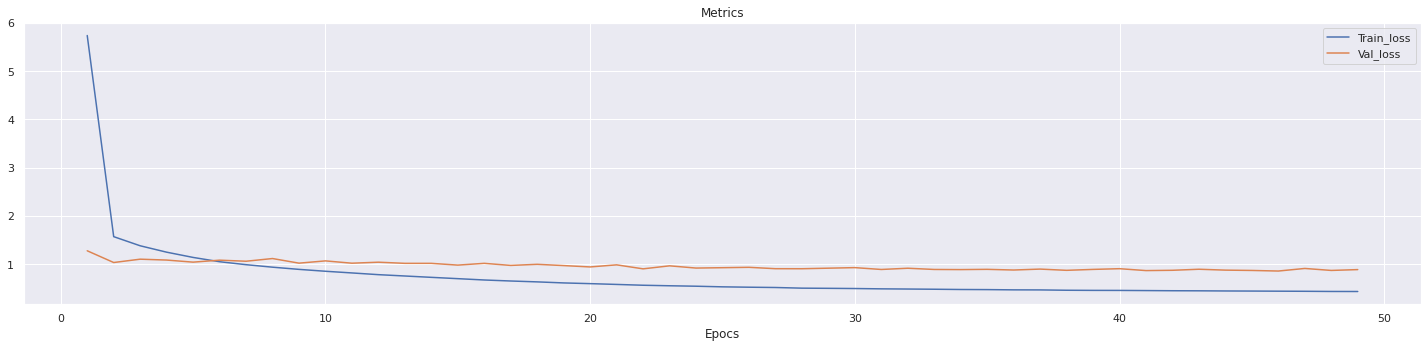

2022-07-23 17:00:01,361 - INFO - {'time': '0:00:08.71', 'epoch': 50, 'train_loss': 0.43166771554833006, 'val_loss': 0.8787339925765991, 'lr': 0.001}


In [21]:
result = model.fit(
    train_dl,
    epochs      = params.epochs,
    loss_fn     = ml.MSELossFn(),
    optimizer   = Adam(
        params       = model.parameters(),
        lr           = params.lr
    ),
    callbacks   = [
        Validation(
            test_dl,
            metrics = { 'val_loss': ml.MSELossFn(float_result=True)},
            each_n_epochs=1
        ),
        ReduceLROnPlateau(metric='val_loss', mode='min', factor=params.lr_factor, patience=params.lr_patience),
        MetricsPlotter(metrics=['train_loss', 'val_loss'], plot_each_n_epochs=2),
        Logger(['time', 'epoch', 'train_loss', 'val_loss', 'patience', 'lr']),
        SaveBestModel(metric='val_loss', path='../weights', experiment_name='nnmf')
    ]
)

Processing:   0%|          | 0/500 [00:00<?, ?it/s]

<Figure size 1440x360 with 2 Axes>

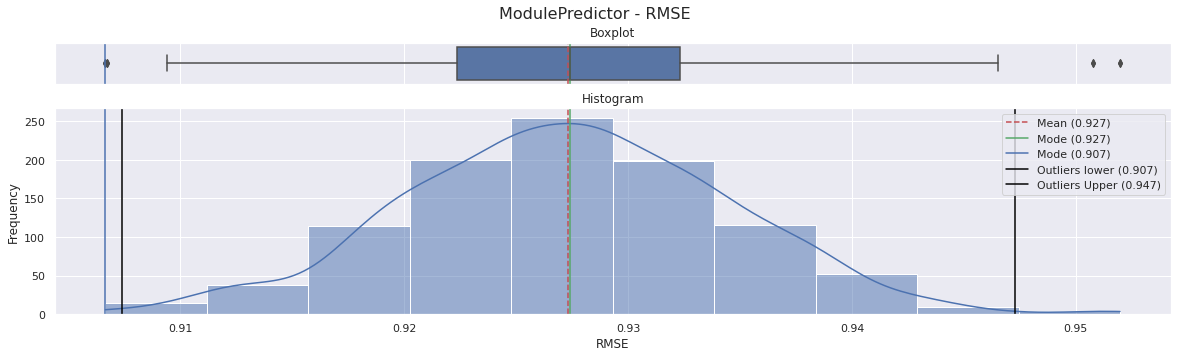


Metrics:



,RMSE
count,1000.000000
mean,0.927314
std,0.007243
min,0.906648
25%,0.922356
50%,0.927419
75%,0.932328
max,0.951971


<Figure size 1440x360 with 2 Axes>

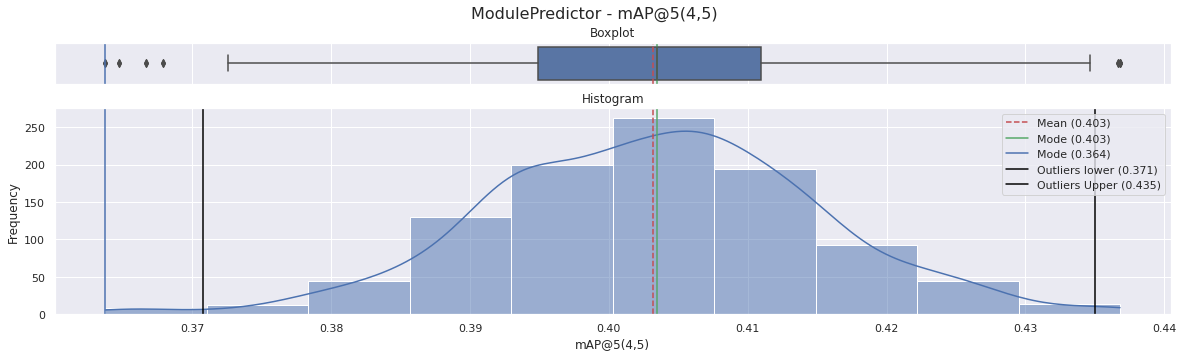


Metrics:



,"mAP@5(4,5)"
count,1000.000000
mean,0.403207
std,0.011915
min,0.363730
25%,0.394876
50%,0.403439
75%,0.410936
max,0.436818


<Figure size 1440x360 with 2 Axes>

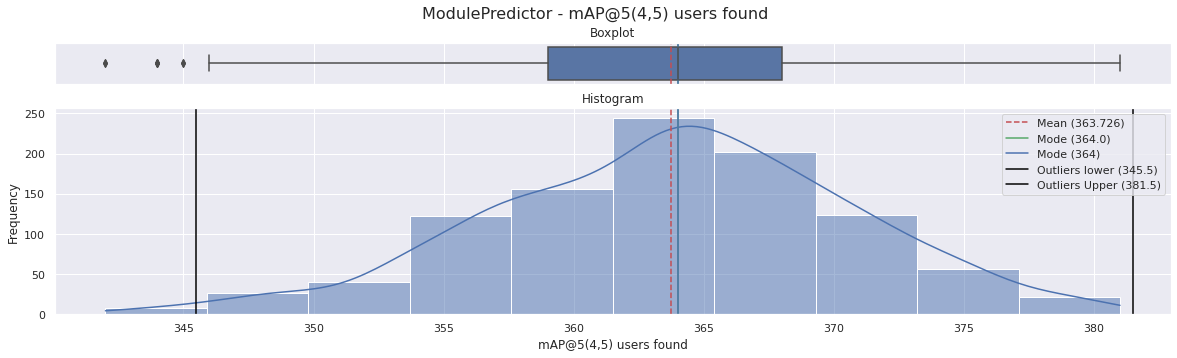


Metrics:



,"mAP@5(4,5) users found"
count,1000.000000
mean,363.726000
std,7.001996
min,342.000000
25%,359.000000
50%,364.000000
75%,368.000000
max,381.000000


In [28]:
PATH = '../weights/2022-07-23_16-59-25--nnmf--epoch_46--val_loss_0.8593634963035583.pt'
model.load_state_dict(torch.load(PATH))

deep_fm_predictor = ml.ModulePredictor(model)

validator = ml.Validator(
    n_samples  = 500,
    batch_size = 10000,
    metrics    = [
        mt.RMSE(),
        mt.MeanAveragePrecisionAtk(user_index=0, k=5, discretizer=dr.between(4, 5))
    ],
    predictors = [deep_fm_predictor]
)

summary = validator.validate(eval_set)

summary.save('../metrics/gfm_bias')
summary = ml.ValidatorSummary.load('../metrics/gfm_bias')

summary.plot(bins=10, show_table=True)